In [196]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [197]:
url = "./datasets/DAT_ASCII_EURUSD_M1_2018.csv"
df = pd.read_csv(url, names=list(["date","open", "high", "low", "close", "volume"]), header=None, sep=";")
df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df.set_axis(df['date'], inplace=True)

# df.drop(columns=["date"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 372607 entries, 2018-01-01 17:00:00 to 2018-12-31 16:59:00
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    372607 non-null  datetime64[ns]
 1   close   372607 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.5 MB


In [198]:
df.head()

,date,close
date,,
2018-01-01 17:00:00,2018-01-01 17:00:00,1.20100
2018-01-01 17:01:00,2018-01-01 17:01:00,1.20030
2018-01-01 17:02:00,2018-01-01 17:02:00,1.20043
2018-01-01 17:03:00,2018-01-01 17:03:00,1.20046
2018-01-01 17:04:00,2018-01-01 17:04:00,1.20048


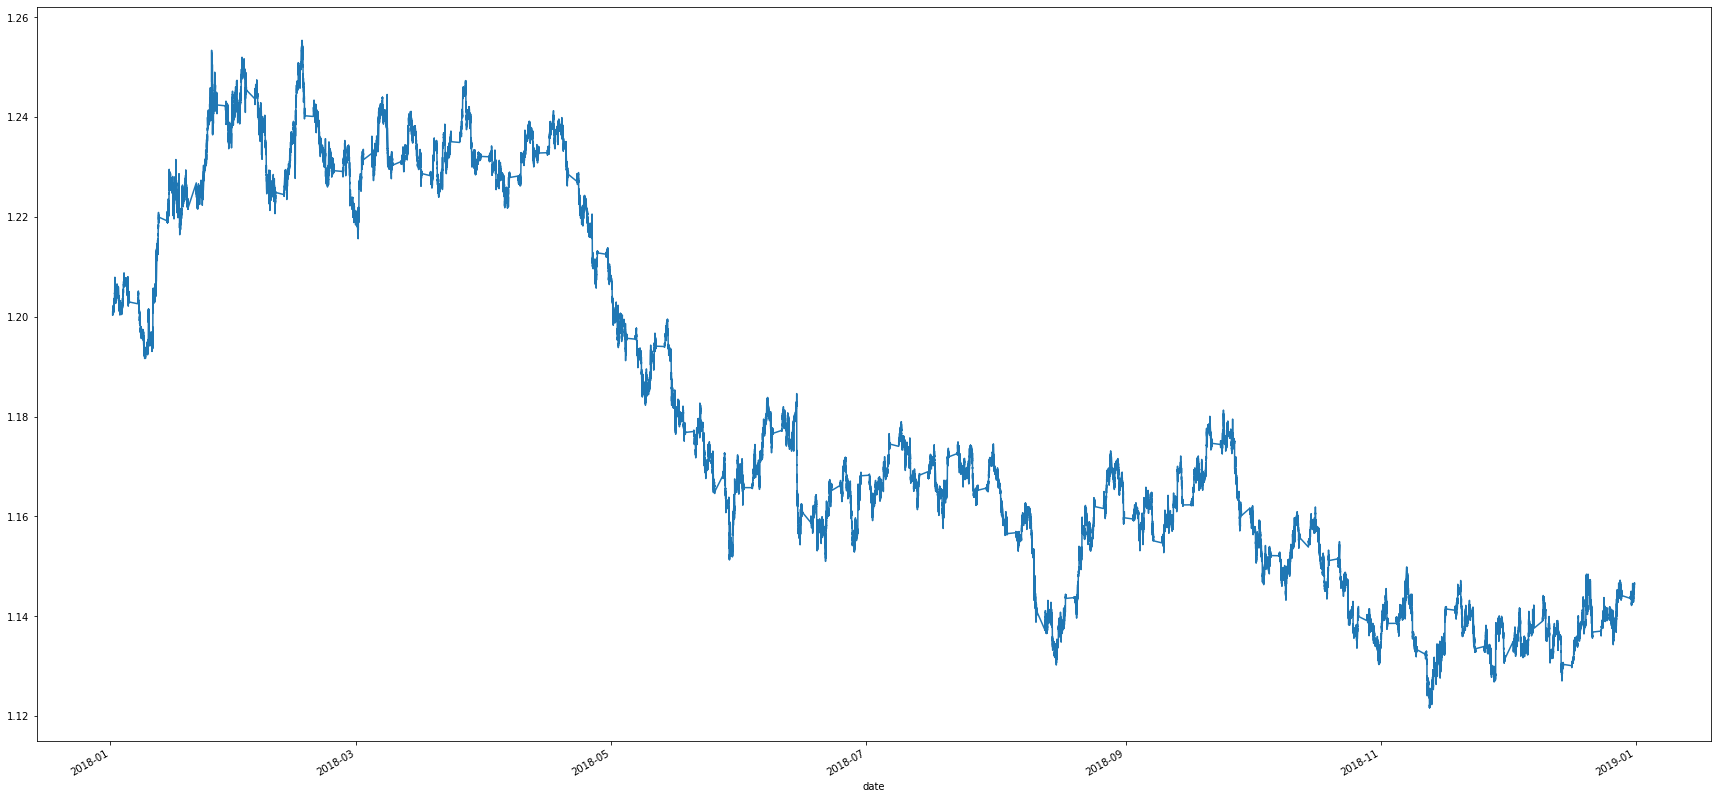

In [199]:
df["close"].plot(figsize=(30,15))

In [200]:
close_data = df['close'].values
close_data = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['date'][:split]
date_test = df['date'][split:]

print(len(close_train))
print(len(close_test))

298085
74522


In [201]:
look_back = 15

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=256, shuffle=True)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=256, shuffle=True)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(
    LSTM(128,
        # activation='relu',
        input_shape=(None,1),
        return_sequences=True
))
model.add(
    LSTM(128,
        input_shape=(look_back,1))
)
model.add(Dropout(0.2))
model.add(Dense(32,activation="relu"))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 5
history=model.fit(train_generator, epochs=num_epochs, verbose=1, validation_data=test_generator)

In [ ]:
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df['date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 120
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [ ]:
prediction = model.predict_generator(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

In [ ]:
minn=np.min([prediction.shape[0], date_test.shape[0]])
print(minn)

In [ ]:
fig, ax = plt.subplots(figsize=(30,15))
ax.plot(date_test,close_test, label='Ground Truth', color='orange')
ax.plot(date_train,close_train, label='Data', color = 'blue')
ax.plot(forecast_dates, forecast, label="XD", color="green")
# ax.plot(date_test[:minn], prediction[:minn], label="XD", color="green")
plt.xlabel('years')
plt.ylabel('prices')
plt.show()

In [ ]:
len(forecast_dates)

In [ ]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE for Chennai Reservoir Levels')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()